# Notebook de modélisation des Emissions de CO2


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn import linear_model
import timeit
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor


In [3]:
def catAnalysis(df, feature, x, y, figsize=(8,5), rotation="45", palette=None, order=None):
    
    data = (pd.DataFrame(df[feature].value_counts())
                .reset_index()
                .rename(columns={'index': x, feature: y}))
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.barplot(x=x, y=y, data=data, palette=palette, order=order);
    plt.xticks(rotation=rotation)
    plt.show()

In [4]:
data = pd.read_csv('cleanData.csv')

In [5]:
firsColumn = data.pop('Age')
data.insert(2, 'Age', firsColumn) 

In [6]:
data

,BuildingType,PrimaryPropertyType,Age,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,TotalGHGEmissions,SiteEnergyUse_log
0,NonResidential,Mixed Use Property,89,7,DOWNTOWN,1.0,2.0,52549.0,65.416836,583.41,7.192677
1,NonResidential,Mixed Use Property,13,7,MAGNOLIA / QUEEN ANNE,1.0,4.0,110785.0,65.416836,91.53,7.025666
2,NonResidential,Small- and Mid-Sized Office,109,7,DOWNTOWN,1.0,6.0,98370.0,45.000000,47.24,6.814640
3,NonResidential,Large Office,68,7,LAKE UNION,1.0,4.0,193788.0,59.000000,116.84,7.224280
4,NonResidential,Small- and Mid-Sized Office,7,2,GREATER DUWAMISH,1.0,3.0,76598.0,76.000000,134.69,6.650987
...,...,...,...,...,...,...,...,...,...,...,...
1260,NonResidential,Other,1,2,GREATER DUWAMISH,1.0,2.0,108036.0,65.416836,91.98,6.698265
1261,NonResidential,Other,3,4,NORTHEAST,1.0,1.0,72000.0,65.416836,67.65,6.466242
1262,NonResidential,K-12 School,1,3,GREATER DUWAMISH,1.0,3.0,45000.0,77.000000,9.24,6.122535
1263,NonResidential,Mixed Use Property,1,7,LAKE UNION,1.0,6.0,345290.0,65.416836,1000.06,7.595101


In [7]:
datacopy = data.copy()

In [8]:
datacopy = datacopy.drop(['ENERGYSTARScore'], axis=1)

In [9]:
target = ['TotalGHGEmissions','SiteEnergyUse_log']

In [10]:
X = datacopy.drop(target, axis=1).values
z = datacopy['SiteEnergyUse_log'].values
y = datacopy['TotalGHGEmissions'].values



In [11]:
from sklearn.preprocessing import LabelEncoder

labelencoder_X_0 = LabelEncoder()
X[:, 4] = labelencoder_X_0.fit_transform(X[:, 4])
X[:, 0] = labelencoder_X_0.fit_transform(X[:, 0])
X[:, 1] = labelencoder_X_0.fit_transform(X[:, 1])

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [13]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [14]:
# Création d'un dataframe dans lequel seront stockées les performances des modèles testés
model_comparison = pd.DataFrame()

Pour éviter les répétitions, la fonction gridsearchCV est créée. Elle permet d'utiliser la fonction gridsearchCV de sklearn pour tester différentes combinaisons d'hyperparamètres et de pouvoir extraire les hyperparamètres associés au meilleur R².

In [15]:
# Définir la fonction gridsearchresult pour obtenir les meilleurs hyperparamètre des différents modèle tester
def gridsearchresults(model, param_grid, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', verbose=3, n_jobs=-1)
    
    # Ajuster sur les différentes combinaisons de GridSearchCV
    grid_result = grid.fit(X_train, y_train)
    
    #Afficher les meilleurs scores (r²) et meilleurs paramètres
    print('Best Score: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)
    
    #Calculer les métrics avec sklearn.metrics et les afficher
    mse = metrics.mean_squared_error(y_test, grid.predict(X_test))
    rmse = np.sqrt(mse) #mse**(0.5)  
    r2 = metrics.r2_score(y_test, grid.predict(X_test))
    
    print("Results of sklearn.metrics:")
    print("RMSE:", rmse)
    print("R-Squared:", r2)

La fonction suivante calcule les diverses métriques que l'on souhaite interpréter: Mean Absolute error (MAE), Root Mean Squarred Error (RMSE), le R squared et enfin le temps de test des combinaisons; et les retourne dans un dictionnaire.

In [16]:
def calcul_metrics(model,X_train, y_train, X_test, y_test):   
    #Calculer les métrics avec sklearn.metrics et les afficher
    mae = metrics.mean_absolute_error(y_test, model.predict(X_test))
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    rmse = np.sqrt(mse) #mse**(0.5)  
    r2 = metrics.r2_score(y_test, model.predict(X_test))
    score = model.score(X_train, y_train)

    
    print("Results of sklearn.metrics:")
    print("Score:", score)
    print("MAE:",mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R-Squared:", r2)
    
    return dict(Score= score, r2 = r2, RMSE = rmse, MAE = mae)

In [17]:
lr  = linear_model.LinearRegression()

# Calculer le temps d'entraînement 
start_time = timeit.default_timer()

# Ajuster les paramètres par rapport au données d'entraînements
lr = lr.fit(X_train, y_train)

duration_lr = timeit.default_timer() - start_time

# Afficher le temps d'entraînement
print ('Durée {:.2f}s'.format(duration_lr))

# Calculer les métriques du modèles et créer un dictionnaire de ces données à insérer dans un df
lr_result = calcul_metrics(lr,X_train, y_train, X_test, y_test)
model_comparison = model_comparison.append(lr_result, ignore_index=True)

Durée 0.30s
Results of sklearn.metrics:
Score: 0.33117207936532833
MAE: 217.60625719160046
MSE: 174630.67978026756
RMSE: 417.88835803389827
R-Squared: -0.10498390879132802


##### SVR

In [18]:
from sklearn.svm import LinearSVR
svr = LinearSVR()

param_grid = {'C' : np.logspace(-4, 0, 5),
             'epsilon' : [ 0.01, 0.1, 0.5, 1, 2],
             'loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
             'max_iter': [100, 1000, 10000]}

In [19]:
gridsearchresults(svr, param_grid, X_train, y_train, X_test, y_test)


Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Score:  0.2507447859505814
Best Params:  {'C': 0.01, 'epsilon': 0.01, 'loss': 'squared_epsilon_insensitive', 'max_iter': 1000}
Results of sklearn.metrics:
RMSE: 377.0889102082115
R-Squared: 0.10024777350302216


In [20]:
svr = LinearSVR( epsilon=0.01, tol=0.0001, C=0.01, loss='squared_epsilon_insensitive', max_iter= 1000)
start_time = timeit.default_timer()

svr = svr.fit(X_train, y_train)

duration_svr = timeit.default_timer() - start_time
print('Durée {:.2f}s'.format(duration_svr))


Durée 0.01s


In [21]:
svr_result = calcul_metrics(svr,X_train, y_train, X_test, y_test)


Results of sklearn.metrics:
Score: 0.3214923483502019
MAE: 194.97726144453014
MSE: 142197.2672347539
RMSE: 377.0905292297248
R-Squared: 0.10024004736046488


In [22]:
model_comparison = model_comparison.append(svr_result, ignore_index=True)

### Random Forest Regression

In [23]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = [int(x) for x in np.linspace (start = 2, stop = X_train.shape[1], num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [10, 50, 100, 300, 500]
min_samples_leaf = [5, 25, 50, 150, 250]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': [2, 2, 3, 4, 4, 5, 6, 6, 7, 8], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [10, 50, 100, 300, 500], 'min_samples_leaf': [5, 25, 50, 150, 250], 'bootstrap': [True, False]}


In [24]:
rfr = RandomForestRegressor()

rfr_random = RandomizedSearchCV(
    estimator = rfr, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 5, 
    verbose=2, 
    random_state=42, 
    n_jobs = -1)
rfr_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [2, 2, 3, 4, 4, 5, 6, 6,
                                                         7, 8],
                                        'min_samples_leaf': [5, 25, 50, 150,
                                                             250],
                                        'min_samples_split': [10, 50, 100, 300,
                                                              500],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                    

In [25]:
rfr_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_features': 7,
 'max_depth': 110,
 'bootstrap': False}

In [26]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [10, 20, 40, 60, 80, 100, 110 ],
    'max_features':[7],
    'min_samples_leaf': [5, 10, 20],
    'min_samples_split': [10, 20, 40],
    'n_estimators': [400, 800]
}

# Create a based model
rfr = RandomForestRegressor()

In [27]:
gridsearchresults(rfr, param_grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 126 candidates, totalling 630 fits
Best Score:  0.44395236318789477
Best Params:  {'bootstrap': False, 'max_depth': 80, 'max_features': 7, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 400}
Results of sklearn.metrics:
RMSE: 406.0667702612185
R-Squared: -0.043350699643705415


In [28]:
rfr =  RandomForestRegressor(bootstrap= False, 
                             max_depth= 20, 
                             max_features= 7, 
                             min_samples_leaf= 5, 
                             min_samples_split=10, 
                             n_estimators= 400)
start_time = timeit.default_timer()
rfr = rfr.fit(X_train, y_train)
duration_rfr = timeit.default_timer() - start_time
print('Durée {:.2f}s'.format(duration_rfr))

Durée 7.55s


In [29]:
rfr_result = calcul_metrics(rfr,X_train, y_train, X_test, y_test)

Results of sklearn.metrics:
Score: 0.6523105089962451
MAE: 165.84109269497972
MSE: 165137.25515363942
RMSE: 406.37083452634664
R-Squared: -0.044913814206878344


In [30]:
model_comparison = model_comparison.append(rfr_result, ignore_index=True)

In [31]:
model_comparison

,Score,r2,RMSE,MAE
0,0.331172,-0.104984,417.888358,217.606257
1,0.321492,0.100240,377.090529,194.977261
2,0.652311,-0.044914,406.370835,165.841093


### Comparaison des modèles

In [32]:
duration = [duration_lr, duration_svr, duration_rfr]
modele = ['Reg Lin','SVR','RandomForest']

In [33]:
model_comparison['duration'] = duration

In [34]:
modele

['Reg Lin', 'SVR', 'RandomForest']

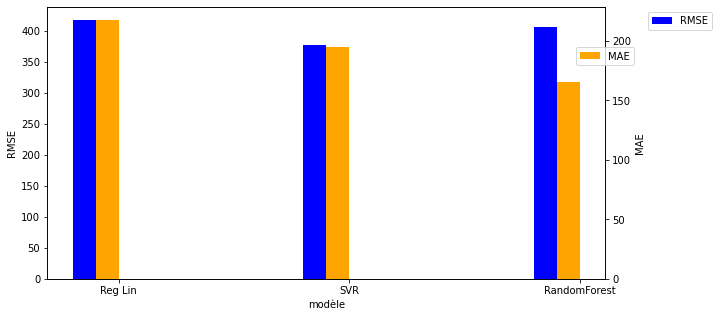

In [40]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
width = 0.1
ind = np.arange(len(model_comparison))
ax.set_ylabel('RMSE')
ax2.set_ylabel("MAE")
ax.set_xlabel('modèle')
ax.bar(ind, model_comparison.RMSE, width, color='blue', label = 'RMSE')
ax2.bar(ind + width, model_comparison.MAE, width, color = 'orange', label = "MAE")
ax.set(xticks = (ind + 1.5 * width), xticklabels = modele)
ax.legend(['RMSE'], bbox_to_anchor = (1.2, 1))
ax2.legend(["MAE"], bbox_to_anchor = (1.06, 0.87))
plt.show()

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='RMSE'>

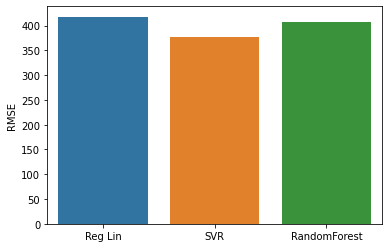

In [39]:
sns.barplot(modele, model_comparison.RMSE)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:ylabel='r2'>

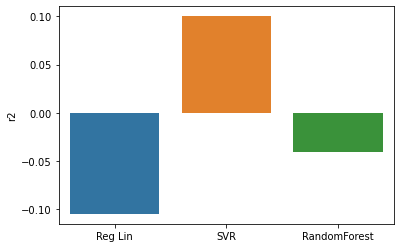

In [40]:
sns.barplot(modele, model_comparison.r2)